# 2018 11 02 Optimisation des Gabors
Youpi ça marche, maintenant il me faut une fonction de sauvegarde des courants de chaque filtre pour pouvoir les inputs sur une cellule V1

Il faut tout passer en fonction

Puis passer en mutlithreading

Et faire des bugfixes

Il est 14h, en avant guingamp

# Partie 1 : Faire des fonctions

In [1]:
# les classiques
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss

In [2]:
#les gabors
def generate_small_gabors(params, N_X, N_Y, N_theta, centers_coordinates, nbr_gabors=6,
                   B_theta= 15 , sf_0 = .05, B_sf = .5):
    '''
    UNUSED
    Given some gabor parameters, a set of coordinates for centering gabors, returns
    a bunch of gabors' phi-space per each theta
    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape
    '''
    
    xs = centers_coordinates[0]
    ys = centers_coordinates[1]
    
    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta /180 * np.pi
    params= {'sf_0':sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)
    
    theta_phi_list = []
    for t in range(N_theta) :
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta) 
        
        phi_list = []
        for gab in range(nbr_gabors) :
            x = xs[gab]
            y = ys[gab]

            for i_phase in range(N_phase):
                phase = i_phase * np.pi/2
                kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
                phi[0, i_phase, :] = lg.normalize(kernel)
            
            phi_list.append(phi)
        theta_phi_list.append(phi_list)
    return theta_phi_list
    
def gabor_connectivity(filters, phi, theta, threshold, on = True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Threshold : the threshold above which (or below, given 'on' param) we select the filters
        on : True if we're passing on center filters, False if we're doing off center filters
    '''
    if on : gab_above_threshold = np.array([*np.where(phi[theta,0] > threshold)], dtype = float).T
    else :gab_above_threshold = np.array([*np.where(phi[theta ,0] < threshold)], dtype = float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters) :
        for gabs in gab_above_threshold :
            if np.all(filt.astype(int) == gabs): filters_in_gabor.append(filt)

    return filters_in_gabor

In [3]:
def generate_small_gabors_coordinates(params, N_X, N_Y, N_theta, centers_coordinates, nbr_gabors=6,
                                   B_theta= 15 , sf_0 = .05, B_sf = .5,
                                     distrib_size = 8, grid_res = 3, on_thresh = .1, off_thresh = -.1,
                                     verbose = True):
    '''
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the gabors
    
    The code iterates through thetas and generate nbr_gabors set of ON/OFF filters
    
    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''
    
    xs = centers_coordinates[0]
    ys = centers_coordinates[1]
    
    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta /180 * np.pi
    params= {'sf_0':sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)
    
    filters_per_theta = []
    for t in range(N_theta) :
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta) 
        
        filters_per_gab = []
        for gab in range(nbr_gabors) :
            x = xs[gab]
            y = ys[gab]

            for i_phase in range(N_phase):
                phase = i_phase * np.pi/2
                kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
                phi[0, i_phase, :] = lg.normalize(kernel)
            
            fx_min = x - distrib_size
            fx_max = x + distrib_size
            fy_min = y - distrib_size
            fy_max = y + distrib_size
            filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T
            if verbose and t == 0 and gab == 0 : print('Filter grid shape', filters_coordinates.shape)
                
            filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                                  phi = phi,theta =  0, threshold =on_thresh)
            off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                                  phi = phi,theta =  0, threshold =off_thresh, on = False)
            
            filters_per_gab.append((filters_in_gabor, off_filters_in_gabor))
            
        filters_per_theta.append(filters_per_gab)
        
    return filters_per_theta



In [4]:
def generate_big_gabors_coordinates(params, N_X, N_Y, N_theta,center_coordinates,
                                   B_theta= 15 , sf_0 = .075, B_sf = .7,
                                     distrib_size = 25, grid_res = 3, on_thresh = .1, off_thresh = -.1,
                                     verbose = True):
    '''
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the one gabor per theta
    
    The code iterates through thetas and generate one gabor set of ON/OFF filters per theta
    
    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        center_coordinates : a 2D array containing two ints for the center of the big gabor
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''
    
    x = center_coordinates[0]
    y = center_coordinates[1]
    
    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta /180 * np.pi
    params= {'sf_0':sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)
    
    filters_per_theta = []
    for t in range(N_theta) :
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta) 

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T
        if verbose and t == 0 : print('Filter grid shape', filters_coordinates.shape)
                
        filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =on_thresh)
        off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =off_thresh, on = False)

        filters_per_theta.append((filters_in_gabor, off_filters_in_gabor))

    return filters_per_theta

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from LogGabor import LogGabor

############
# Constantes
############
gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

video = np.load('montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

total_time = 1000 #ms, temps de simulation
filter_size = 2.

distrib_size = 8
grid_res = 3

centers_coordinates = np.array([[35, 20, 35, 10, 20, 35]
                            ,[35, 20, 10, 35, 35, 20]])

Video shape (54, 54, 4096)


In [6]:
gsgc = generate_small_gabors_coordinates(params = gabors_parameterfile, N_X = 54, N_Y = 54, N_theta = 12,
                     centers_coordinates = centers_coordinates, distrib_size = distrib_size,
                        grid_res = grid_res)

Filter grid shape (36, 2)


In [7]:
#Data structure is, per list index, gsgc[theta][gabor][0=ON;1=OFF][specific tuple of coordinates]
print('Example : ')
print(gsgc[0][4][0])

Example : 
[array([18, 27]), array([18, 30]), array([18, 33]), array([18, 36]), array([18, 39]), array([18, 42]), array([21, 27]), array([21, 30]), array([21, 33]), array([21, 36]), array([21, 39]), array([21, 42])]


In [8]:
gbgc = generate_big_gabors_coordinates(params = gabors_parameterfile, N_X = 54, N_Y = 54, N_theta = 12,
                     center_coordinates = np.array([[27], [27]]))

Filter grid shape (289, 2)


In [9]:
#For big gabor data structure is gbgc[theta][0=ON;1=OFF][specific tuple of coordinates]
print(len(gbgc[0][1]))

15


# Génerer un Gabor et y associer des filtres

NameError: name 'phi' is not defined

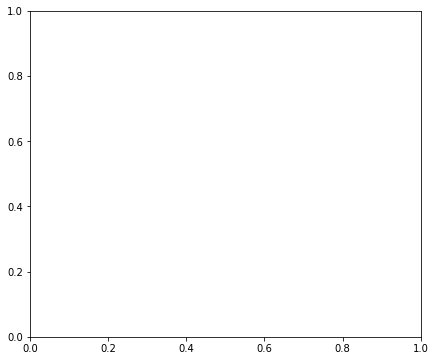

In [10]:
fig, ax = plt.subplots(figsize = (7,6))
ax.imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
#fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_coordinates :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'orange',
               alpha = .8)
    
for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'red')
    
for filt in off_filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'blue')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor connectivity for V1 columns')
plt.tight_layout()

# Comparison 1 : One big Gabor per orientation AKA Full Field Gabor
## Laptop : Wall time: 1min 56s
Simplifié en 25 RF par orientation 

In [ ]:
%%time
# GABOR
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.075, 'B_sf': .07, 'B_theta': B_theta}

N_theta, N_phase = 12, 2
theta = np.linspace(0, np.pi, N_theta)

phi = np.zeros((N_theta, N_phase, N_X, N_Y))

for i_theta in range(N_theta):
    x = N_X/2
    y = N_Y/2
    params.update(theta=i_theta*np.pi/N_theta)
    for i_phase in range(N_phase):
        
        phase = i_phase * np.pi/2
        kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
        phi[i_theta, i_phase, :] = lg.normalize(kernel)
        
        
        
#CONSTANTS
total_time = 1000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

distrib_size = 8
fx_min = x - distrib_size
fx_max = x + distrib_size
fy_min = y - distrib_size
fy_max = y + distrib_size
grid_res = 3

filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)  

filters_per_theta = []
stimuli = video
#FILTERS IN GABOR
for theta in tqdm(range(N_theta), 'Iterating through thetas') :
    filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  theta, threshold =0)

    off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  theta, threshold =0, on = False)
    
    #CAlCULER TOUT LES FILTRES
    convo_list = []
    st_list = []
    on_st_levels = []
    
    #LES FILTRES ON 
    for filt in range(len(filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= filters_in_gabor[filt][0],
                              y_trans = filters_in_gabor[filt][1]) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        on_st_level = []
        for i in range(total_time):
            on_st_level.append(np.max(st[:,:,i]))
        on_st_levels.append(on_st_level)
        
    convo_list = []
    st_list = []
    off_st_levels = []
    
    #LES FILTRES OFF 
    for filt in range(len(off_filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= off_filters_in_gabor[filt][0],
                              y_trans = off_filters_in_gabor[filt][1],
                              end_multiplier = 1.) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        off_st_level = []
        for i in range(total_time):
            off_st_level.append(np.max(st[:,:,i]))
        off_st_levels.append(off_st_level)
    
    filters_per_theta.append((on_st_levels, off_st_levels))

In [ ]:
import numpy as np
import pylab as plt
import itertools

theta_nbr = 10

on_st_levels = filters_per_theta[theta_nbr][0]
off_st_levels = filters_per_theta[theta_nbr][1]
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('black')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 10

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])

ax.set_xticklabels([])

ax = fig.add_subplot(1, 2,1)
theta_nbr = 6

on_st_levels = filters_per_theta[theta_nbr][0]
off_st_levels = filters_per_theta[theta_nbr][1]
chans = len(on_st_levels) + len(off_st_levels) #channels


ax.set_facecolor('black')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 10

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel('Time (ms)')
plt.suptitle(x = .5, y = .94,t = 'Full-Field Gabor, Theta = 0 and 90 °\nThe stimulus is mainly horizontal')

plt.subplots_adjust(wspace = .1)

#plt.savefig('./figs/2018_10_30_Comparison_Large_Gabors.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 


# Comparison 2 : Small Gabors
## Laptop : Wall time: 4min 20s


In [ ]:
from LogGabor import LogGabor
import random

N_theta, N_phase = 12, 2
thetas = np.linspace(0, np.pi, N_theta)

fig, axs = plt.subplots(N_theta,nbr_gabors,figsize = (10,18))
for t in range(N_theta) :
    
    N_X, N_Y, N_frame = video.shape
    N_X = int(N_X)
    N_Y = int(N_Y)

    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))

    B_theta = 15 /180 * np.pi


    N_phase = 2
    theta = thetas[t]
    phi = np.zeros((t, N_phase, N_X, N_Y))
    params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}
    params.update(theta=theta)

    nbr_gabors = 6 
    xs = [40, 20, 40, 10, 20, 40]
    ys = [40, 20, 10, 40, 40, 20]
    
    xs = [35, 20, 35, 10, 20, 35]
    ys = [35, 20, 10, 35, 35, 20]
    
    for gab in range(nbr_gabors) :
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        distrib_size = 8
        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        grid_res = 3

        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

        #print('Filter array size', filters_coordinates.shape)


        filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =.3)

        off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =-0.1, on = False)


        axs[t][gab].imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
        #fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

        '''for filt in filters_coordinates :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'orange',
                       alpha = .8)'''

        for filt in filters_in_gabor :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 15**2, facecolor = 'None', 
                                 edgecolor = 'red')

        for filt in off_filters_in_gabor :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 15**2, facecolor = 'None', 
                                 edgecolor = 'blue', alpha = .6)
        
        axs[t][gab].set_ylabel((r"$\Theta$ = %.2f°" % (theta*180/np.pi)) if gab == 0 else '')
        axs[t][gab].set_xlim(54,0)
        axs[t][gab].set_ylim(0,54)
        axs[t][gab].set_yticklabels([])
        axs[t][gab].set_xticklabels([])
        
        

    '''plt.suptitle(x = .5, y = .7, 
                 t ='Theta = %.2f°' % (theta*180/np.pi))'''
#plt.subplots_adjust(left = .1, right = .9, bottom = .1, top = .7,hspace = .01, wspace = .01)
plt.tight_layout()
plt.savefig('./figs/2018_11_02_Gab_vs_thetas.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
    #plt.savefig('./figs/2018_11_02_GabTheta%s.pdf'%theta, format = 'pdf', bbox_inches = 'tight')
    #plt.pause(.1)

In [ ]:
%%time
from LogGabor import LogGabor
import random

N_theta, N_phase = 12, 2
thetas = np.linspace(0, np.pi, N_theta)

gabors_per_theta = []
stimuli = video
# loop through thetas
for theta in tqdm(range(N_theta), 'Iterating through thetas') :
    
    N_X, N_Y, N_frame = video.shape
    N_X = int(N_X)
    N_Y = int(N_Y)

    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))

    B_theta = 15 /180 * np.pi


    N_phase = 2
    theta = thetas[theta]
    phi = np.zeros((1, N_phase, N_X, N_Y))
    params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}
    params.update(theta=theta)

    nbr_gabors = 6 
    xs = [40, 20, 40, 10, 20, 40]
    ys = [40, 20, 10, 40, 40, 20]
    
    xs = [30, 20, 30, 10, 20, 30]
    ys = [30, 20, 10, 30, 30, 20]
    
    
    filters_per_theta = []
    #loop through gabors
    for gab in range(nbr_gabors) :
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)
        
        distrib_size = 8
        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        grid_res = 3

        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

        #print('Filter array size', filters_coordinates.shape)


        filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =.3)

        off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =-0.1, on = False)

        #LES FILTRES ON 
        convo_list = []
        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
            try :
                X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                                       xres = filter_res, yres = filter_res,
                                       x_trans= filters_in_gabor[filt][0],
                                      y_trans = filters_in_gabor[filt][1]) 
                t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

                #Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                              *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                convo_list.append(ys)
                st_list.append(st)

                on_st_level = []
                for i in range(total_time):
                    on_st_level.append(np.max(st[:,:,i]))
                on_st_levels.append(on_st_level)
            except :
                print('Error : The RF is outside the image')
                pass
        
        #LES FILTRES OFF 
        convo_list = []
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
            try :
                X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                                       xres = filter_res, yres = filter_res,
                                       x_trans= off_filters_in_gabor[filt][0],
                                      y_trans = off_filters_in_gabor[filt][1],
                                      end_multiplier = 1.) 
                t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

                #Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                              *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                convo_list.append(ys)
                st_list.append(st)

                off_st_level = []
                for i in range(total_time):
                    off_st_level.append(np.max(st[:,:,i]))
                off_st_levels.append(off_st_level)
            except :
                print('Error : The RF is outside the image')
                pass


        filters_per_theta.append((on_st_levels, off_st_levels))
    gabors_per_theta.append(filters_per_theta)


In [ ]:
#the structure is weird as fuck, here is how it works.
print('We used %s thetas' % len(gabors_per_theta))
print('There is %s gabor per theta' %len(gabors_per_theta[0]))
print('There are %s types of filters per gabor' %len(gabors_per_theta[0][0]))
print('For the first theta and first gabor, we have %s ON filters' %len(gabors_per_theta[0][0][0]))

print('For the first theta and first gabor, we have %s OFF filters' %len(gabors_per_theta[0][0][1]))

In [ ]:
plt.plot(gabors_per_theta[0][1][1][2]) #theta = 0, premier gabor, RF on, deuxième RF de la liste